## To-do List
### 0. Video
* For each pixel removing mean value


### 1. Demixing steps
* Initialization of rois
* Consider using SNR x Local correlation for cell detection using CNN
* Using TF-spike version of CNMF for demixing
* Show weight matrices for demixed components


### 2. Spike detection
* Find possible correlation of spike events with subthreshold activity
    * Both repolarization and spike with high nonlinearity comparing to other dynamics
    * Repolarization derivative?
* Comparing to old pipeline
    * Using simultaneous ephys and voltron as a reference
    * Using noisy neuron (in old pipeline) as a comparison

3. Model of single neuron activity
* LIF model
    * Simultaneous ephys and voltron?


In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1. Load denoised data

In [2]:
Y = np.load('tmpData/Y_svd.npy')
Ysg = np.load('tmpData/Y_svd_sg.npy')
ave = Y.mean(axis=-1)
Y_ = Ysg - Y

In [3]:
# from scipy import signal
# # linear
# # Y_ = signal.detrend(Y, axis=-1)
# Ysg = signal.savgol_filter(Y, 511, 3, axis=-1)
# np.save('tmpData/Y_svd_sg', Ysg)

In [4]:
from utils.video import videoWrite
videoWrite(Y.transpose(2, 0, 1), 'Y.mp4')
videoWrite(Y_.transpose(2, 0, 1), 'Y_.mp4')

In [5]:
from spatialDenoising.trefide import estimate_noise
d1, d2, T = Y_.shape
sn = estimate_noise(Y_.reshape((d1*d2,T), order='F')).reshape((d1,d2), order='F')

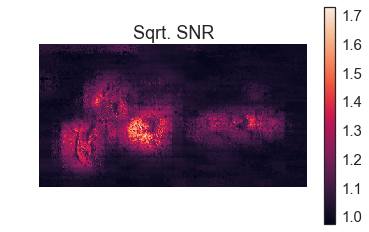

In [6]:
plt.imshow(Y_.std(axis=-1)/sn)
plt.colorbar()
plt.title('Sqrt. SNR')
plt.axis('off')
plt.show()

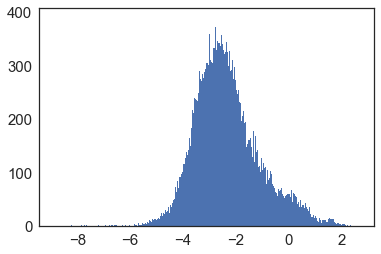

In [7]:
plt.hist(np.log(Y_.std(axis=-1).flatten()), 1000)
plt.show()

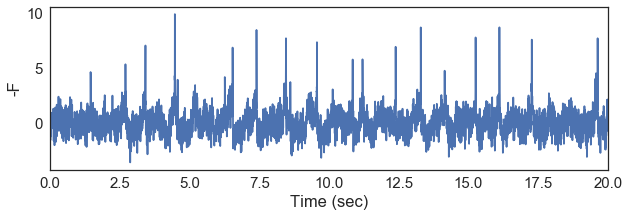

In [8]:
# crop average activity in a boxed region
plt.figure(figsize=(10, 3))
plt.plot(np.arange(T)/300, Y_[80:100, 100:120, :].mean(axis=1).mean(axis=0))
plt.xlabel('Time (sec)')
plt.xlim([0, 20])
plt.ylabel('-F')
plt.show()

### 1.1 Run a median + MAD filter on denosing data

In [9]:
snr_ratio = Y_.std(axis=-1)/sn < 1.1

In [10]:
s_ratio = Y_.std(axis=-1) < np.median(Y_.std(axis=-1).flatten())

In [11]:
Y_med = np.median(Y_, axis=-1)
Y_mad = np.median(np.abs(Y_ - Y_med[:, :, np.newaxis]), axis=-1)

In [12]:
Y_thre = Y_ - (Y_med + 1 * Y_mad)[:, :, np.newaxis]
Y_thre[Y_thre<0] = 0
Y_thre[np.broadcast_to(snr_ratio[:, :, np.newaxis], Y_thre.shape)] = 0
# Y_thre[np.broadcast_to(s_ratio[:, :, np.newaxis], Y_thre.shape)] = 0

### 1.2 Comparing denoised data with threshould version

In [13]:
videoWrite(Y_thre.transpose(2, 0, 1), 'Y_thre.mp4')

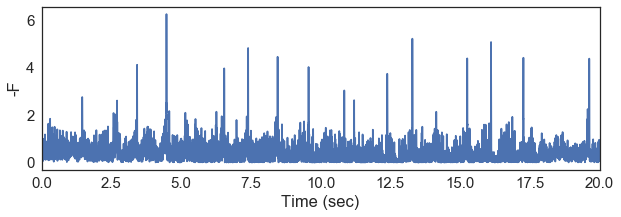

In [14]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(T)/300, Y_thre[80:100, 100:120, :].mean(axis=1).mean(axis=0))
# plt.plot(np.arange(T)/300, Y_thre[180:200, 0:20, :].mean(axis=1).mean(axis=0))
plt.xlabel('Time (sec)')
plt.xlim([0, 20])
plt.ylabel('-F')
plt.show()

In [15]:
corrMat = cm.local_correlations(Y_thre)
corrMat[np.isnan(corrMat)] = 0
pnrMat = Y_thre.max(axis=-1)/Y_thre.std(axis=-1)
pnrMat[np.isnan(pnrMat)] = 0

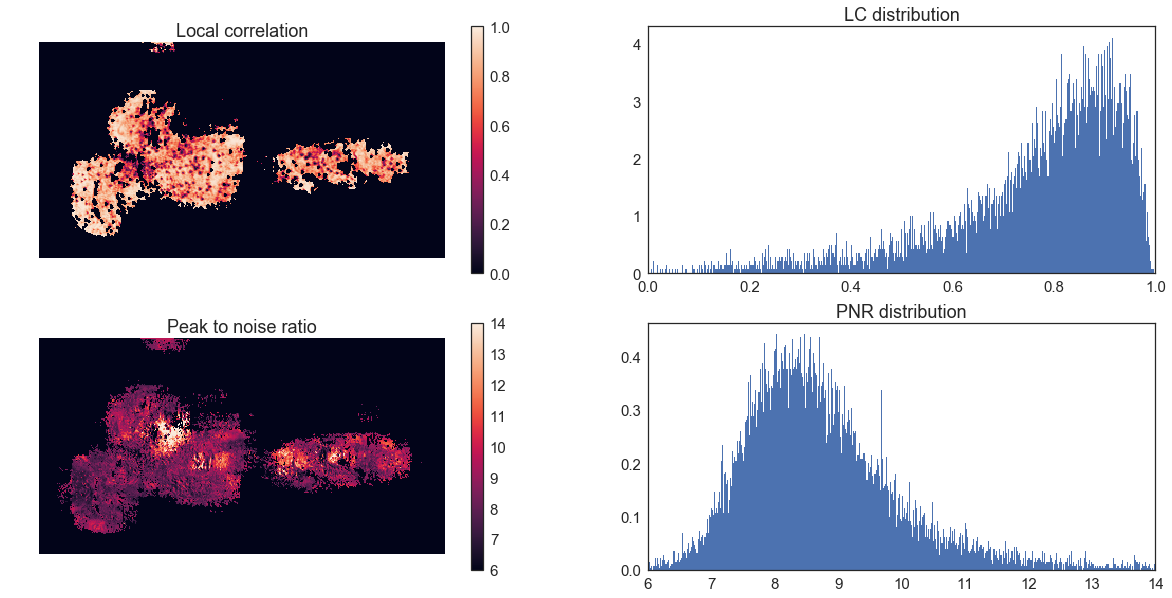

In [16]:
# plot PNR image and local correlation image
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
im = ax[0,0].imshow(corrMat, vmin=0, vmax=1)
ax[0,0].set_title('Local correlation')
ax[0,0].set_axis_off()
fig.colorbar(im, ax=ax[0,0])
ax[0,1].hist(corrMat[corrMat>0].flatten(), 1000, density=True)
ax[0,1].set_xlim([0,1])
ax[0,1].set_title('LC distribution')
im = ax[1,0].imshow(pnrMat, vmin=6, vmax=14)
ax[1,0].set_title('Peak to noise ratio')
ax[1,0].set_axis_off()
fig.colorbar(im, ax=ax[1,0])
ax[1,1].hist(pnrMat[pnrMat>0].flatten(), 1000, density=True)
ax[1,1].set_xlim([6,14])
ax[1,1].set_title('PNR distribution')
plt.show()

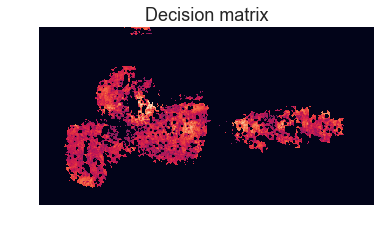

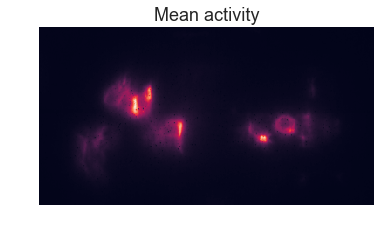

In [17]:
corrMat_ = corrMat.copy()
pnrMat_ = pnrMat.copy()
corrMat_[corrMat_<0.5] = 0
pnrMat_[pnrMat_<6] = 0

plt.imshow(pnrMat_*corrMat_)
plt.title('Decision matrix')
plt.axis('off')
plt.show()

plt.imshow(ave)
plt.title('Mean activity')
plt.axis('off')
plt.show()

## 2. Identify neurons/components

### 2.1 Initialization

In [18]:
from spatialDenoising import demix
from trefide.solvers.lagrangian import lpdas, ipm
from trefide.solvers.constrained import cpdas
from spatialDenoising import util_plot

In [19]:
A, C, centers, b, f = demix.initialize_vimaging_highpass(data_raw=Y_thre.transpose([2,0,1]), patch_radius=20, min_corr=.5,
                                                    min_pnr=6, max_neurons=20, rank_bg=2, min_pixel=30, boundary=3,
                                                    verbose=False, noise_thresh=3)

In total,  20 neurons were initialized.


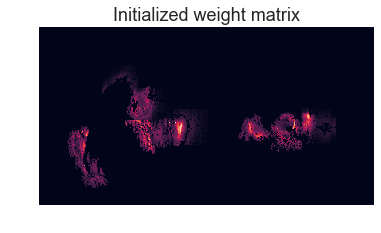

In [20]:
from skimage.filters import roberts
from scipy.ndimage.morphology import binary_dilation
img = A.todense().sum(axis=1).reshape(d2, d1).T
plt.imshow(img, vmin=0, vmax=3)
plt.title('Initialized weight matrix')
plt.axis('off')
plt.show()

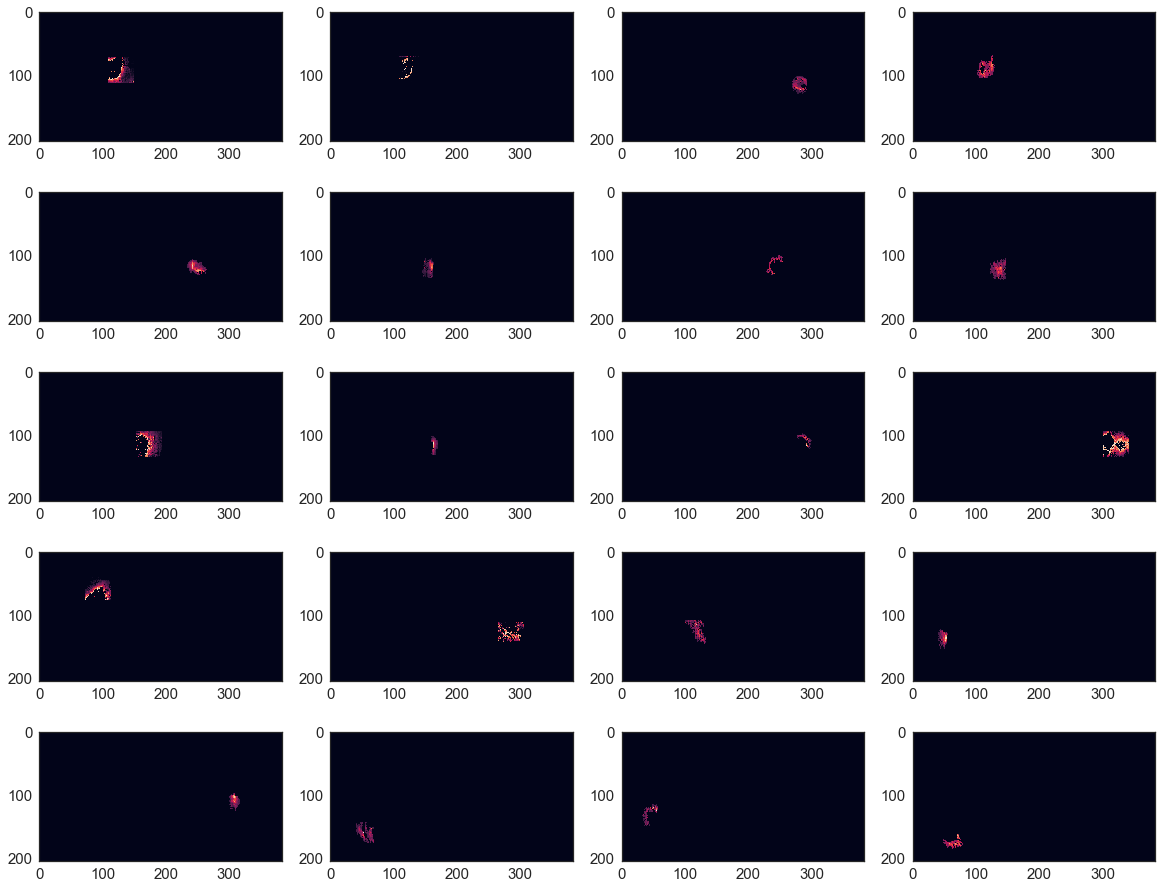

In [21]:
fig, ax = plt.subplots(5, 4, figsize = (20, 16))
ax = ax.flatten()

for itr, nA in enumerate(A.T):
    img = np.array(nA.todense().reshape(d2, d1).T)
    xbound = np.where((img>0).sum(axis=0)>0)[0]
    ybound = np.where((img>0).sum(axis=1)>0)[0]
    ax[itr].imshow(img)
#     ax[itr].set_xlim([xbound[0], xbound[-1]])
#     ax[itr].set_ylim([ybound[0], ybound[-1]])
#     ax[itr].set_axis_off()
#     ax[itr].set_aspect('equal')

plt.show()

### 2.2 Refine -- Constrained NMF
Using l1 trend filtering regularization encourages smoothness and allows spiking:

$A, C, b, f = \arg\min ||Y-AC-bf^T||_F^2 - \sum_{k=1}^K \lambda_k||D^{(2)}C_k||_1$

s.t. $C\ge0$, $A\ge0$, and A is sparse and local.

where A are spatial components, b is a spatial background, C are temporal components and f is a temporal background.

In [22]:
sA, sb, tC, tf = demix.nmf_iter(Y_, C, f, A.todense(), b, sn, nb=2, n_iter=10, mergingthr=0.85)

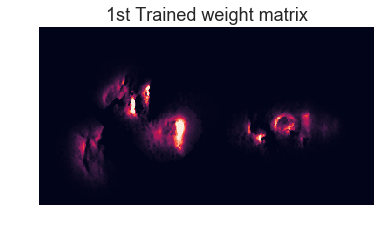

In [23]:
from skimage.filters import roberts
from scipy.ndimage.morphology import binary_dilation

img = sA.todense().sum(axis=1).reshape(d2, d1).T
plt.imshow(img, vmax = 150)
plt.title('1st Trained weight matrix')
plt.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(5, 4, figsize = (20, 16))
ax = ax.flatten()

for itr, nA in enumerate(sA.tocsr().T):
    img = np.array(nA.todense().reshape(d2, d1).T)
    xbound = np.where((img>0).sum(axis=0)>0)[0]
    ybound = np.where((img>0).sum(axis=1)>0)[0]
    ax[itr].imshow(img, vmax=80)
    ax[itr].set_xlim([xbound[0], xbound[-1]])
    ax[itr].set_ylim([ybound[0], ybound[-1]])
    ax[itr].set_axis_off()
#     ax[itr].set_aspect('equal')

plt.show()

#### 2.2.1 Second round of refine by removing the components with low weights

### 2.3 Generate reconstruction of signal

In [25]:
# Y_hat = sA_.dot(tC_) + sb_.dot(tf_)
# Y_hat = np.reshape(Y_hat, (d1,d2,T), order='F')

In [26]:
# Y_res = Y - Y_hat

### 2.4 Go through 2.1 to 2.3 for the addtional decomposition of residual signal (skipped)

### 2.5 Remove junk component, which is close to white noise

In [27]:
# fig, ax = plt.subplots(tC_.shape[0], 1, figsize=(20, 120))
# ax = ax.flatten()
# for itr, (nA, nC) in enumerate(zip(sA_.todense().T, tC_)):
#     ax[itr].plot(nC)
# plt.show()

### 2.6 Get Temporal signal

In [28]:
def recompute_C_matrix(sig, A):
    d1, d2, T = sig.shape
    return np.linalg.inv(np.array(A.T.dot(A).todense())).dot(A.T.dot(np.reshape(sig, (d1*d2,T), order='F')))

In [29]:
C_ = recompute_C_matrix(Y_, sA)

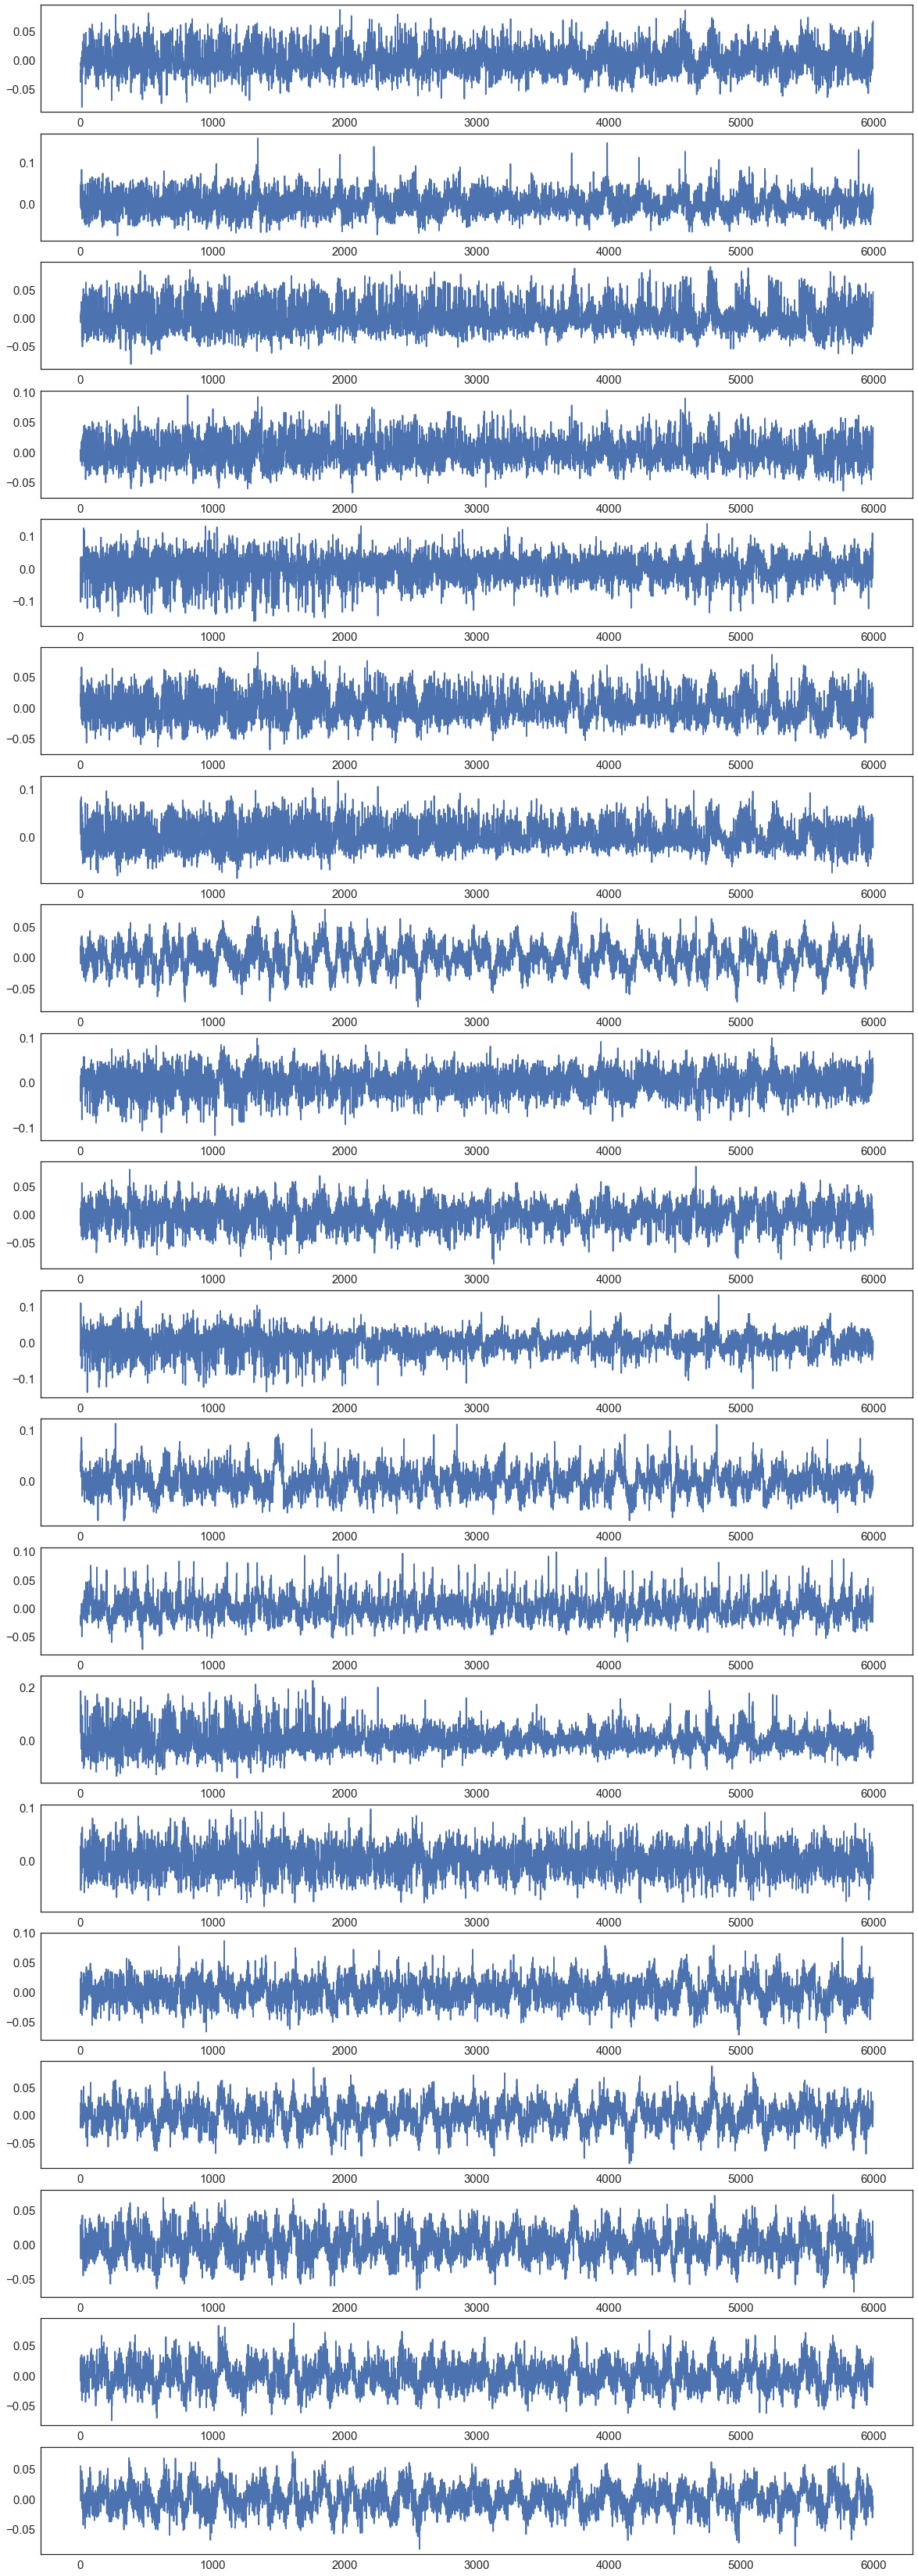

In [30]:
fig, ax = plt.subplots(20, 1, figsize=(20, 60))
ax = ax.flatten()

for ax_, Ct in zip(ax, C_):
    ax_.plot(Ct)
    
plt.show()

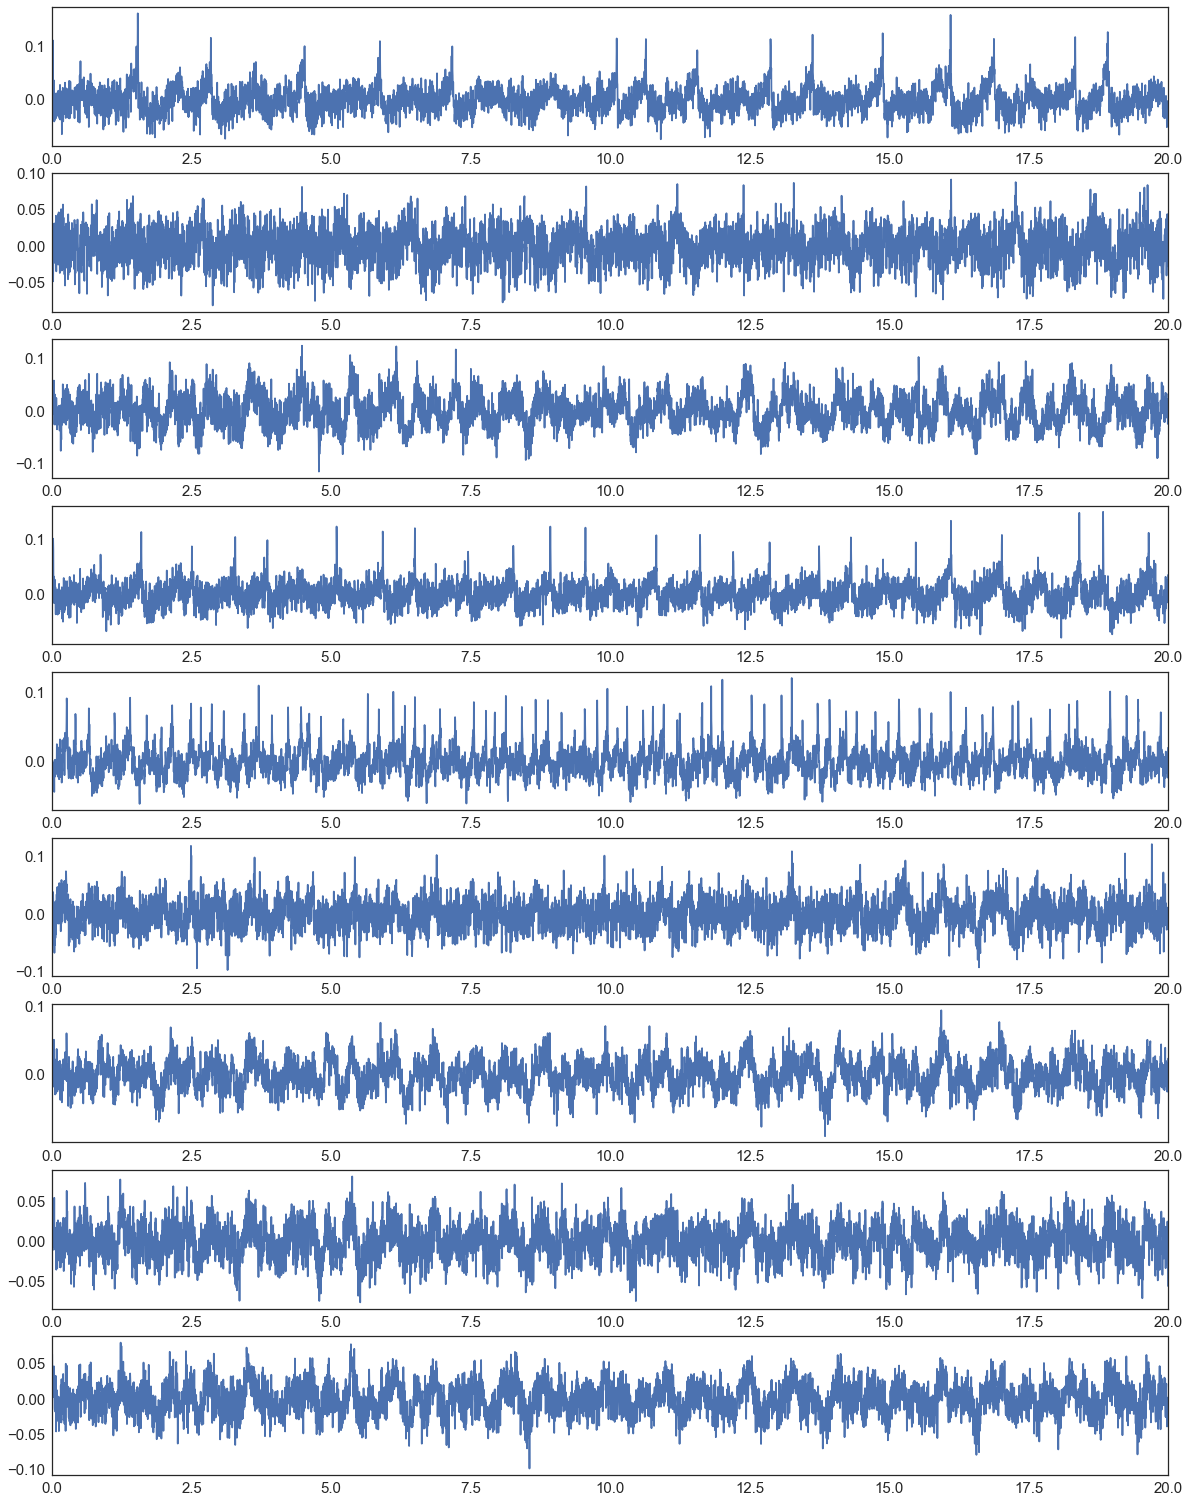

In [10]:
C__ = np.load('Error_TF_signals.npy')
C_rm = C__[[2, 3, 5, 6, 12, 15, 16, 17, 19],:]
fig, ax = plt.subplots(C_rm.shape[0], 1, figsize=(20, C_rm.shape[0]*3))
ax = ax.flatten()

for ax_, Ct in zip(ax, C_rm):
    ax_.plot(np.arange(len(Ct))/300, Ct)
    ax_.set_xlim([0, 20])
plt.show()

In [3]:
C__.shape

(20, 6000)

## 3. Trend filtering

### 3.1 L1TF

In [32]:
from scipy import signal
from trefide.solvers.lagrangian import lpdas, ipm
from trefide.solvers.constrained import cpdas
from trefide.temporal import TrendFilter
from peakutils import peak
from scipy.sparse.linalg import lsqr, lsmr

def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
    x, istop, itn, normr = lsmr(D.T, y)[:4]
    return np.linalg.norm(x, ord=np.inf)

In [33]:
denoised = []
for idx, trace_ in enumerate(C_):
    filters = TrendFilter(len(trace_))
    try:
        denoised.append(filters.denoise(trace_))
    except:
        print(idx)
        denoised.append(np.zeros(len(trace_)))

2


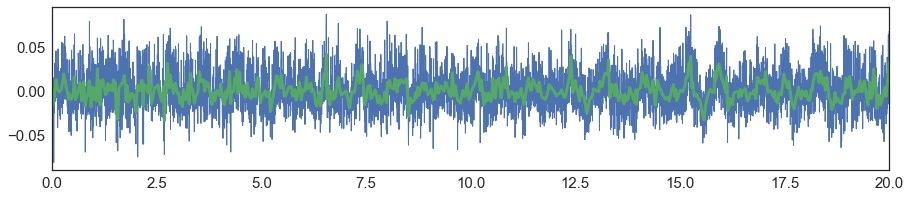

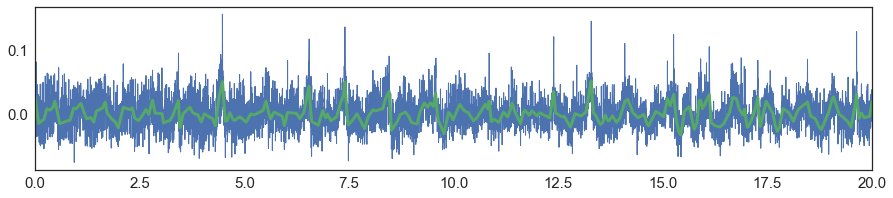

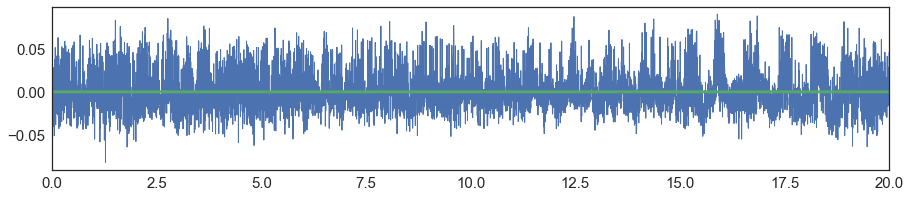

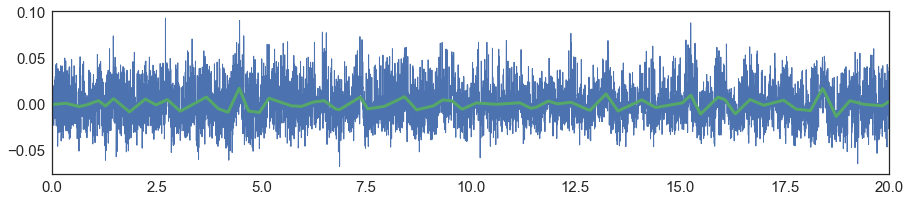

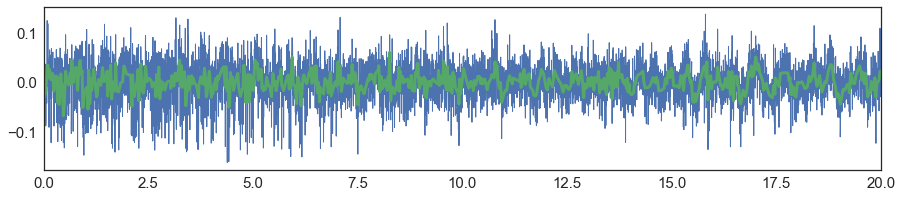

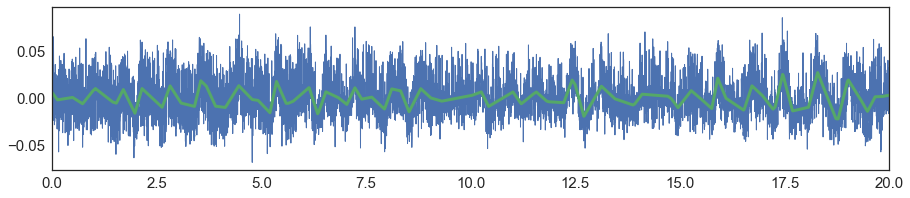

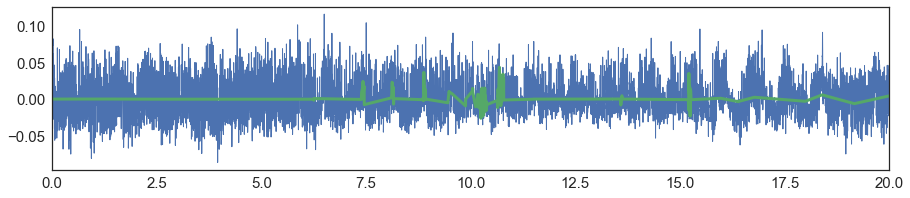

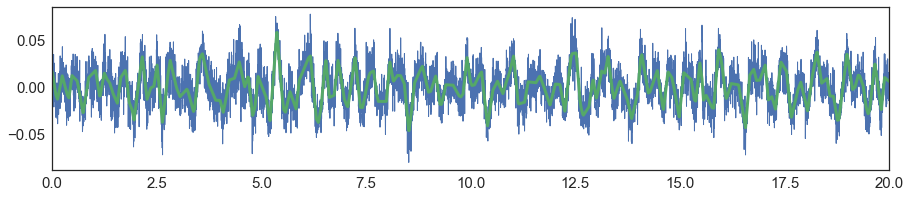

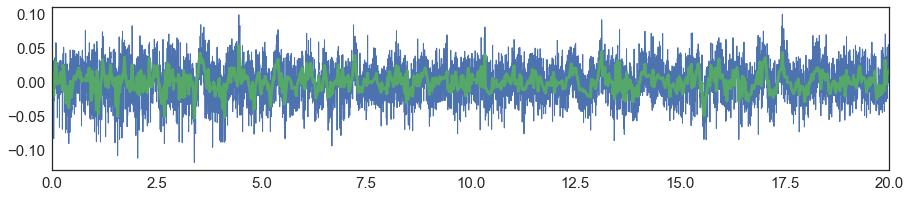

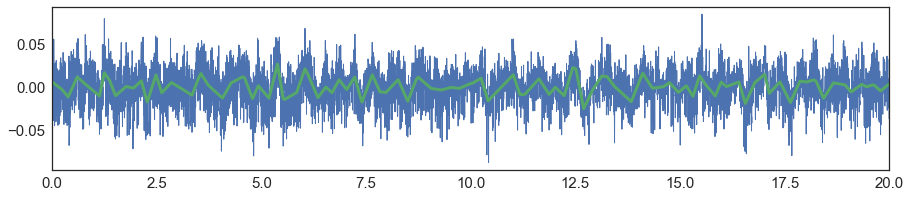

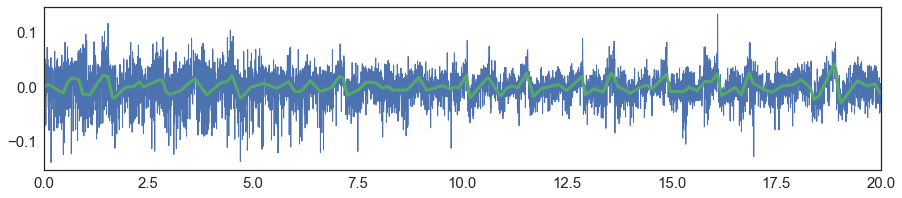

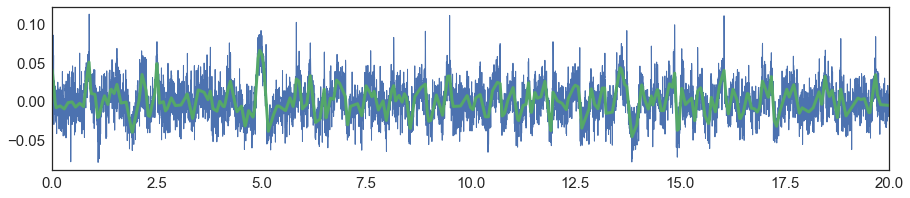

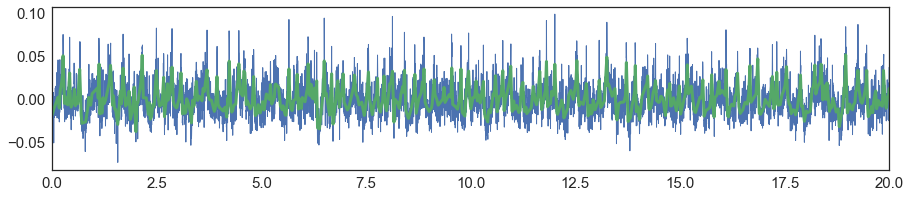

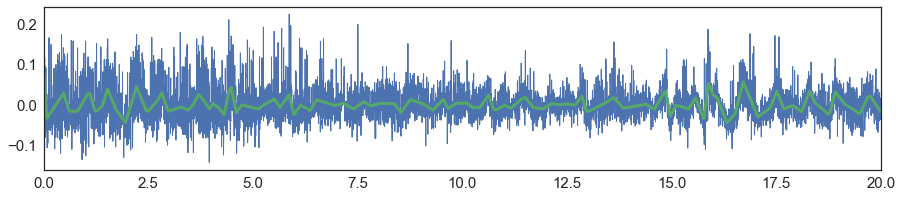

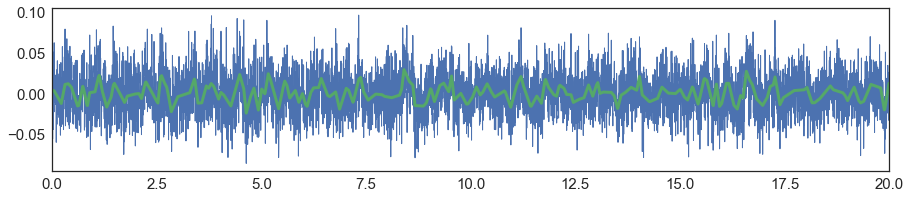

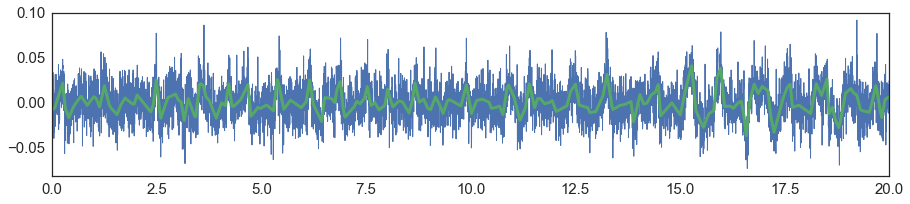

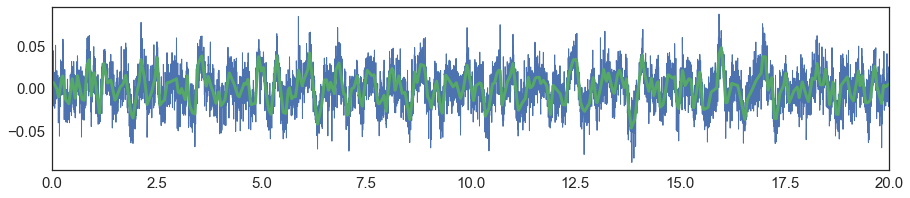

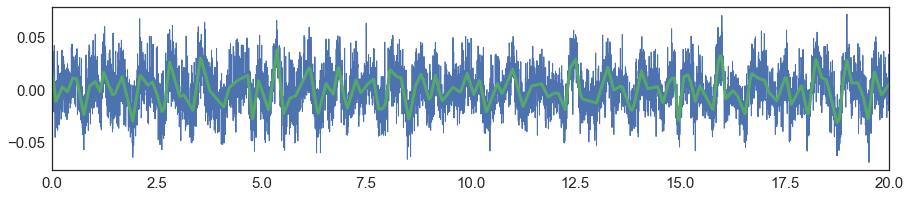

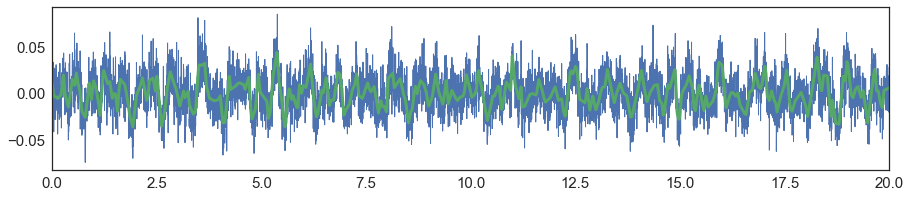

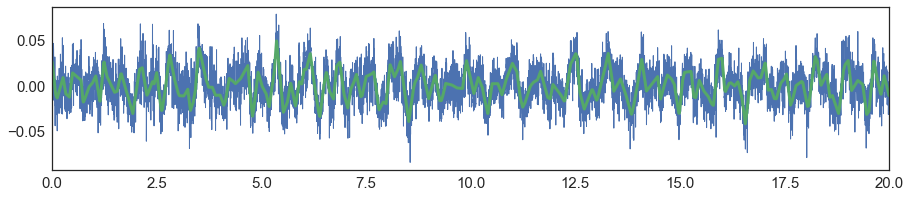

In [37]:
for trace_, x_ in zip(C_, denoised):
    plt.figure(figsize=(15, 3))
    plt.plot(np.arange(len(trace_))/300, trace_, linewidth=1)
    plt.plot(np.arange(len(trace_))/300, x_, linewidth=3)
    plt.xlim([0, 20])
    plt.show()